In [1]:
import networkx as nx
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
from io import StringIO
import re

from networkx.drawing.nx_pydot import read_dot
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, datasets
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
%matplotlib inline

from sklearn.cluster import DBSCAN

pd.set_option('display.max_columns', 500)


In [2]:
metadata_train = pd.read_csv("data/training_set_metadata.csv", sep = ";")

In [3]:
metadata_to_predict = pd.read_excel("data/test_set_metadata_to_predict.xlsx")

In [46]:
metadata_predict = pd.read_excel("data/busss.xlsx")


In [47]:
# Sélectionner toutes les lignes et toutes les colonnes à partir de la deuxième (index 1)
counts = metadata_train.iloc[:, 1:].sum(axis=0)
total_rows = metadata_train.iloc[:, 1:].shape[0]
percentage = (counts / total_rows) * 100
variables_below_10 = percentage[percentage < 0.001].index.tolist()
print("Variables avec moins de 1% de 1 :", variables_below_10)
len( variables_below_10)

Variables avec moins de 1% de 1 : []


0

In [212]:
variables_0_F1 = [
    "64-bit execution via heavens gate",
    "yoda",
    "xorcrypt",
    "write file on Linux",
    "worm",
    "wise",
    "winzip",
    "check for Windows sandbox via genuine state",
    "check for Windows sandbox via process name",
    "validate payment card number using luhn algorithm with lookup table",
    "usb-autorun",
    "check for hardware breakpoints",
    "start minifilter driver",
    "stealth",
    "checks-hostname",
    "contains-pe",
    "linked against aPLib",
    "create new application domain in .NET",
    "create process on Linux",
    "create reverse shell on Linux",
    "create thread bypassing process freeze",
    "packed with enigma",
    "packed with kkrunchy",
    "krunchy",
    "macro-powershell",
    "linked against wolfCrypt",
    "lock file",
    "lolbin",
    "macho",
    "northstar",
    "mysql-communication",
    "molebox",
    "decompress data using UCL",
    "decompress data via IEncodingFilterFactory",
    "packed with Pepack",
    "npack",
    "honeypot",
    "hosts-modifier",
    "inject shellcode using a file mapping object",
    "installshield",
    "nsrl",
    "installstub",
    "irc-communication",
    "kkrunchy",
    "obtain TransmitPackets callback function via WSAIoctl",
    "obsidium",
    "packed with PESpin",
    "packed with PECompact",
    "reference DNS over HTTPS endpoints",
    "reference public RSA key",
    "decode data using Base64 via VBMI lookup table",
    "packed with Perplex",
    "packed with TSULoader",
    "create virtual file system in .NET",
    "decompress HTTP response via IEncodingFilterFactory",
    "ftp",
    "expressor",
    "read from mailslot",
    "read file on Linux",
    "protect spawned processes with mitigation policies",
    "pklite",
    "repeated-clock-access",
    "relocatable",
    "register minifilter driver",
    "apatch",
    "anorganix",
    "apk",
    "ssh-communication",
    "software-collection",
    "packed with petite",
    "packed with y0da crypter",
    "patch Antimalware Scan Interface function",
    "petite",
    "extract HTTP body",
    "ezip",
    "fsg",
    "get HTTP document via IWebBrowser2",
    "gamehouse",
    "get HTTP request URI",
    "hash data using aphash",
    "exe32pack",
    "hash data using rshash",
    "resolve function by djb2 hash",
    "dex",
    "dxpack",
    "dingboy",
    "efi",
    "dyn-class",
    "elf",
    "enumerate files on Linux",
    "encrypt data using Sosemanuk",
    "packed with pebundle",
    "exestealth",
    "exeshield",
    "execute shellcode via Windows fibers",
    "execryptor",
    "simulate CTRL ALT DEL",
    "smtp-communication",
    "shellcode",
    "pebundle",
    "check for protected handle exception",
    "sets-process-name",
    "shared-lib",
    "check process job object",
    "pcguard",
    "patch process command line",
    "suspicious-dns",
    "sudo",
    "cexe",
    "change file permission on Linux",
    "attachment",
    "arm",
    "suspicious-udp",
    "telnet-communication",
    "trojan",
    "tunneling",
    "terminate process via kill",
    "telock",
    "thinstall",
    "reference Base58 string",
    "send HTTP response",
    "check for unexpected memory writes",
    "asprotect",
    "packman",
    "decompress data using LZO",
    "rlpack",
    "encrypt data using RC4 via SystemFunction033",
    "service-scan",
    "check for trap flag exception",
    "exploit",
    "armadillo",
    "rebuild import table"
]


In [207]:
variables_0_F1_aya = [
    "pecompact",
    "nsrl",
    "installshield",
    "self-delete",
    "checks-user-input",
    "clipboard",
    "idle",
    "Service-scan",
    "expressor",
    "lock file",
    "krunchy",
    "write file on Linux",
    "macho",
    "hash data using aphash",
    "worm",
    "cexe",
    "terminate process via kill",
    "trojan",
    "usb-autorun",
    "apatch",
    "arm",
    "telnet-communication",
    "sudo",
    "validate payment card number using luhn algorithm with lookup table",
    "winzip",
    "ftp",
    "ezip",
    "gamehouse",
    "get HTTP request URI",
    "exestealth",
    "exeshield",
    "enumerate files on Linux",
    "mysql-communication",
    "npack",
    "linked against wolfCrypt",
    "lolbin",
    "create reverse shell on Linux",
    "packed with PESpin",
    "dyn-class",
    "dex",
    "dingboy",
    "packed with kkrunchy",
    "packed with TSULoader",
    "create process on Linux",
    "pklite",
    "checks-hostname",
    "read file on Linux",
    "protect spawned processes with mitigation policies",
    "create virtual file system in .NET",
    "decompress data via IEncodingFilterFactory",
    "decompress HTTP response via IEncodingFilterFactory",
    "reference public RSA key",
    "reference DNS over HTTPS endpoints",
    "resolve function by djb2 hash",
    "relocatable",
    "check for Windows sandbox via genuine state",
    "check for Windows sandbox via process name",
    "check process job object",
    "shellcode",
    "stealth",
    "yoda"
]


In [198]:
variables_0_F1_old = [
    "enumerate files on Linux",
    "get HTTP request URI",
    "ezip",
    "hash data using aphash",
    "exestealth",
    "expressor",
    "trojan",
    "telnet-communication",
    "sudo",
    "arm",
    "stealth",
    "cexe",
    "apatch",
    "usb-autorun",
    "winzip",
    "validate payment card number using luhn algorithm with lookup table",
    "terminate process via kill",
    "worm",
    "write file on Linux",
    "ftp",
    "gamehouse",
    "dex",
    "npack",
    "mysql-communication",
    "macho",
    "lolbin",
    "exeshield",
    "linked against wolfCrypt",
    "lock file",
    "krunchy",
    "packed with PESpin",
    "packed with TSULoader",
    "packed with kkrunchy",
    "create process on Linux",
    "decompress HTTP response via IEncodingFilterFactory",
    "dyn-class",
    "dingboy",
    "read file on Linux",
    "checks-hostname",
    "protect spawned processes with mitigation policies",
    "pklite",
    "decompress data via IEncodingFilterFactory",
    "create reverse shell on Linux",
    "create virtual file system in .NET",
    "reference DNS over HTTPS endpoints",
    "check for Windows sandbox via genuine state",
    "reference public RSA key",
    "relocatable",
    "resolve function by djb2 hash",
    "check process job object",
    "check for Windows sandbox via process name",
    "shellcode",
    "yoda"
] 

In [41]:

colonnes_a_remplir = [col for col in variables_below_10 if col in metadata_predict.columns]
metadata_predict.loc[:, colonnes_a_remplir] = -1
print("Mise à jour effectuée pour les colonnes :", colonnes_a_remplir)
len(colonnes_a_remplir)

Mise à jour effectuée pour les colonnes : ['apatch', 'arm', 'cexe', 'check for Windows sandbox via genuine state', 'check for Windows sandbox via process name', 'checks-hostname', 'contains-pe', 'create new application domain in .NET', 'create reverse shell on Linux', 'create virtual file system in .NET', 'dex', 'dingboy', 'dyn-class', 'efi', 'enumerate files on Linux', 'exe32pack', 'exeshield', 'exestealth', 'expressor', 'ezip', 'ftp', 'gamehouse', 'get HTTP request URI', 'hash data using aphash', 'honeypot', 'inject shellcode using a file mapping object', 'installstub', 'krunchy', 'linked against wolfCrypt', 'lock file', 'macho', 'northstar', 'npack', 'obtain TransmitPackets callback function via WSAIoctl', 'packed with PECompact', 'packed with TSULoader', 'packed with pebundle', 'pklite', 'reference public RSA key', 'relocatable', 'resolve function by djb2 hash', 'smtp-communication', 'stealth', 'sudo', 'telnet-communication', 'telock', 'thinstall', 'validate payment card number usi

52

In [ ]:
colonnes_a_remplir = [col for col in variables_below_10 if col in metadata_predict.columns]

# Remplacer uniquement si la valeur est différente de 1 (typiquement 0 ou NaN)
for col in colonnes_a_remplir:
    metadata_predict.loc[metadata_predict[col] != 1, col] = -1

print("Mise à jour effectuée pour les colonnes :", colonnes_a_remplir)
print("Nombre de colonnes modifiées :", len(colonnes_a_remplir))


Mise à jour effectuée pour les colonnes : ['64-bit execution via heavens gate', 'yoda', 'xorcrypt', 'write file on Linux', 'worm', 'wise', 'winzip', 'check for Windows sandbox via genuine state', 'check for Windows sandbox via process name', 'validate payment card number using luhn algorithm with lookup table', 'usb-autorun', 'check for hardware breakpoints', 'start minifilter driver', 'stealth', 'checks-hostname', 'contains-pe', 'linked against aPLib', 'create new application domain in .NET', 'create process on Linux', 'create reverse shell on Linux', 'create thread bypassing process freeze', 'packed with enigma', 'packed with kkrunchy', 'krunchy', 'macro-powershell', 'linked against wolfCrypt', 'lock file', 'lolbin', 'macho', 'northstar', 'mysql-communication', 'molebox', 'decompress data using UCL', 'decompress data via IEncodingFilterFactory', 'packed with Pepack', 'npack', 'honeypot', 'hosts-modifier', 'inject shellcode using a file mapping object', 'installshield', 'nsrl', 'insta

In [45]:
df = metadata_predict
# Modifier les lignes 10 à 20 (index de 9 à 19)
df.loc[9:19] = df.loc[9:19].replace(0, 1)

# Sauvegarder dans un nouveau fichier
df.to_excel("aya_seuil_0.1.xlsx", index=False)

print("Modifications terminées. Fichier sauvegardé sous : fichier_modifie.csv")

Modifications terminées. Fichier sauvegardé sous : fichier_modifie.csv


# Modèle PCA

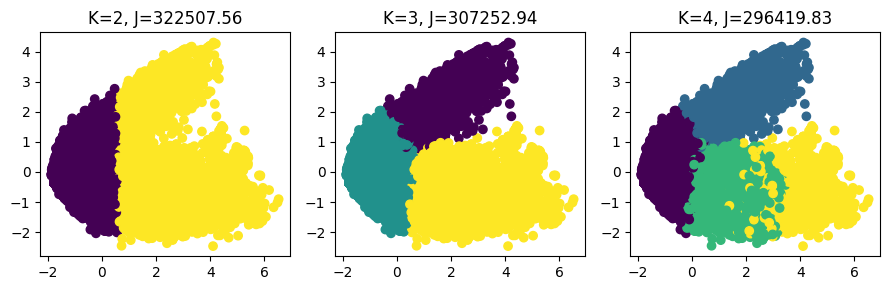

In [7]:
X = metadata_train.iloc[:, 1:] 

# Réduction de dimension avec PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Appliquer K-Means avec différents nombres de clusters
km2 = cluster.KMeans(n_clusters=2, random_state=42, n_init=10).fit(X)
km3 = cluster.KMeans(n_clusters=3, random_state=42, n_init=10).fit(X)
km4 = cluster.KMeans(n_clusters=4, random_state=42, n_init=10).fit(X)
km5 = cluster.KMeans(n_clusters=5, random_state=42, n_init=10).fit(X)
km6 = cluster.KMeans(n_clusters=6, random_state=42, n_init=10).fit(X)

# Affichage des résultats
plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km2.labels_, cmap='viridis')
plt.title("K=2, J=%.2f" % km2.inertia_)

plt.subplot(132)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km3.labels_, cmap='viridis')
plt.title("K=3, J=%.2f" % km3.inertia_)

plt.subplot(133)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km4.labels_, cmap='viridis')
plt.title("K=4, J=%.2f" % km4.inertia_)


plt.tight_layout()
plt.show()


In [8]:

def train_kmeans_filling_model(metadata_train, n_clusters=3):
    """
    Entraîne un modèle KMeans sur les données binaires et retourne les clusters et leurs moyennes.
    :param metadata_train: DataFrame contenant les données binaires (0 et 1)
    :param n_clusters: Nombre de clusters à utiliser
    :return: Modèle KMeans entraîné et moyennes des clusters
    """
    X = metadata_train.iloc[:, 1:]  # Exclure l'ID si présent

    # Clustering KMeans
    kmeans = cluster.KMeans(n_clusters, random_state=42, n_init=10).fit(X)

    metadata_train["Cluster"] = kmeans.labels_
    # Calcul des moyennes des comportements par cluster
    cluster_means = metadata_train.iloc[:, 1:].groupby("Cluster").mean()

    return kmeans, cluster_means


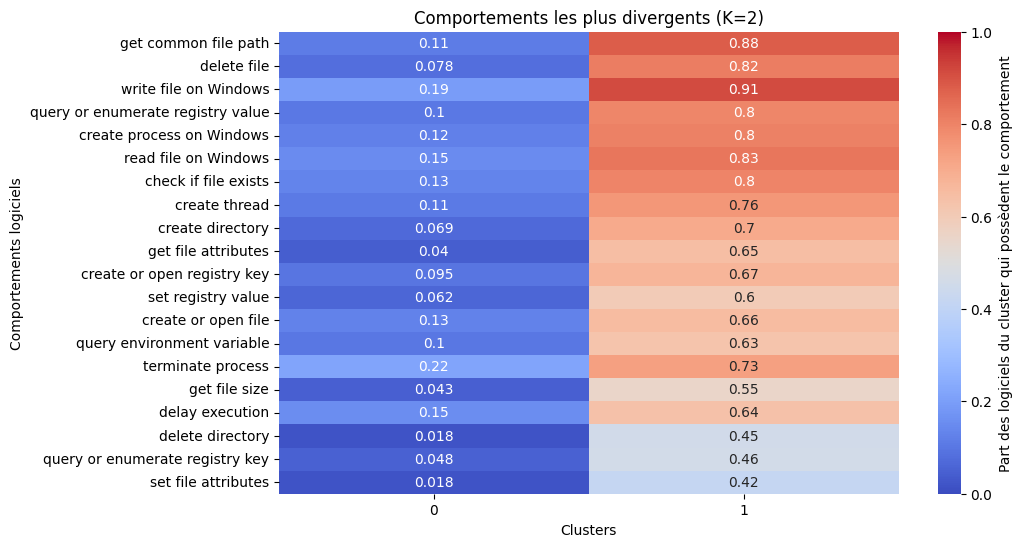

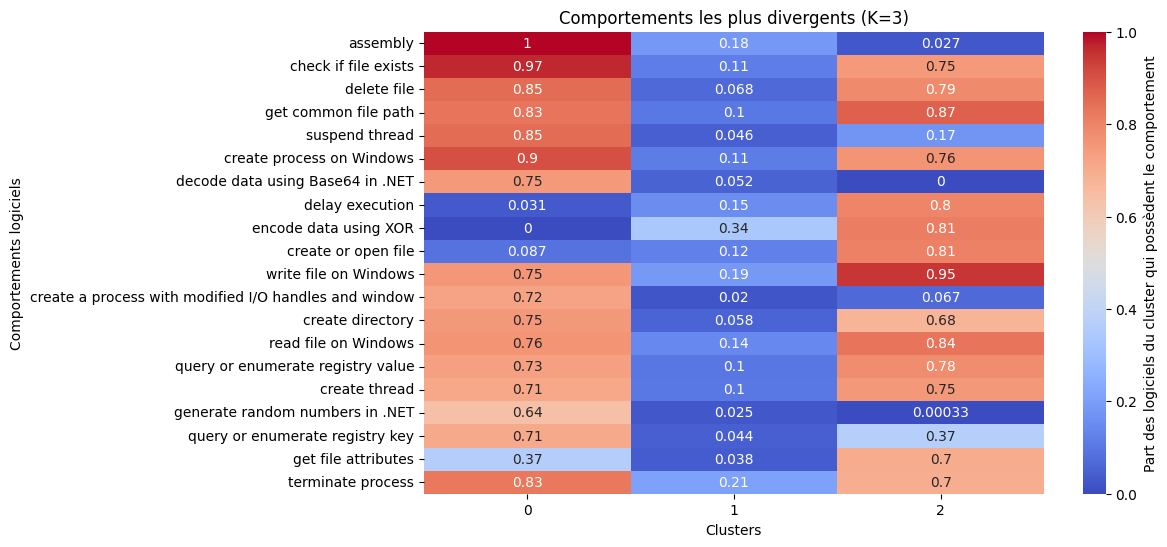

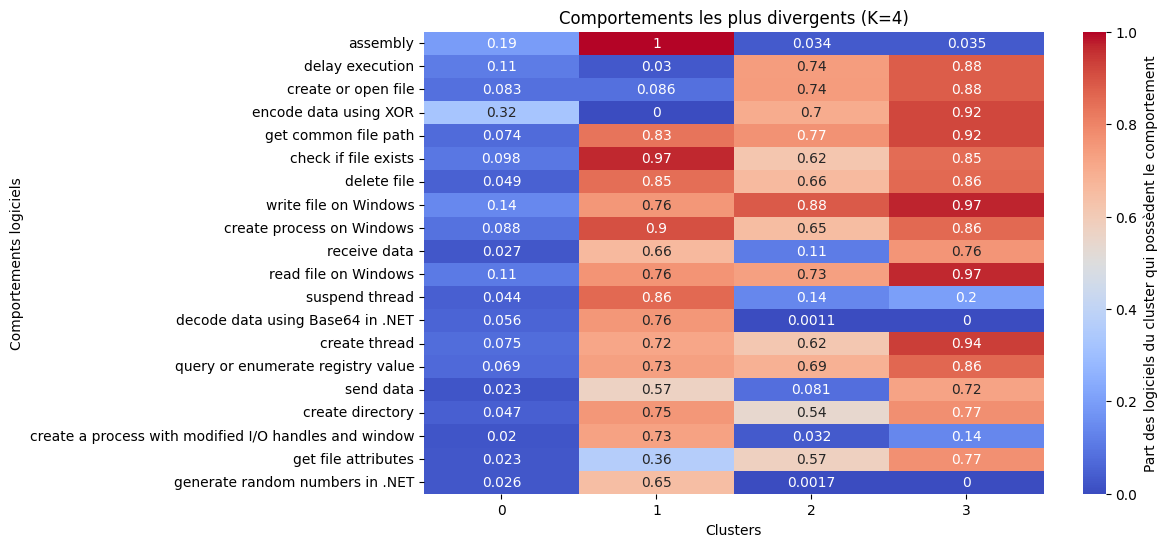

In [9]:
list_cluster = [2,3,4]


kmeans_models = {}
cluster_means_dict = {}

for nb_cluster in list_cluster:
    # Ajouter les labels des clusters aux données
    metadata_train = pd.read_csv("data/training_set_metadata.csv", sep = ";")

    kmeans, cluster_means =train_kmeans_filling_model(metadata_train, n_clusters=nb_cluster)

    kmeans_models[nb_cluster] = kmeans
    cluster_means_dict[nb_cluster] = cluster_means

    # Identifier les comportements les plus distinctifs (ceux qui varient le plus entre clusters)
    divergent_features = cluster_means.var().sort_values(ascending=False).head(20).index

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(cluster_means[divergent_features].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Part des logiciels du cluster qui possèdent le comportement')

    plt.title(f"Comportements les plus divergents (K={nb_cluster})")
    plt.ylabel("Comportements logiciels")  # Inversé
    plt.xlabel("Clusters")  # Inversé
    plt.show()

J'aimerai construire un algorithme de remplissage des binaires pour de nouvelles lignes (nouveaux logiciels). Le problème que je suis capable de prédire seulement quelques comportement. J'aimerai en input donner les valeurs des comportements que je suir d'avoir bien prédit, et en output donner tous les comportements. L'agorithme doit regarder la classe la plus probable du logiciel par rapport aux profil des cluster et appliquer les valeurs majoritaires du cluster auquel le logiciel à le plus de chance d'appartenir.

Préparer les données :

Avoir les moyennes des comportements par cluster (comme on l'a fait précédemment).
Avoir les valeurs connues pour le logiciel à prédire.
Calculer la similarité entre les comportements observés du logiciel et chaque cluster (par exemple, en utilisant la distance Euclidienne ou d'autres mesures de distance).

Identifie le cluster le plus probable :

Une fois le cluster le plus probable trouvé, tu peux extraire les valeurs majoritaires pour ce cluster (par exemple, la valeur la plus fréquente pour chaque comportement).
Compléter les comportements manquants avec ces valeurs majoritaires du cluster identifié.

In [10]:

def fill_missing_behaviors(known_behaviors, kmeans, cluster_means):
    """
    
    Complète les comportements inconnus en fonction du cluster le plus probable.
    :param known_behaviors: Liste avec des valeurs connues (0, 1) et des -1 pour les inconnues.
    :param kmeans: Modèle KMeans entraîné.
    :param cluster_means: Moyennes des comportements par cluster.
    :return: Comportements complétés, Cluster prédit
    """
    known_behaviors = np.array(known_behaviors).reshape(1, -1)
    # Filtrer les indices des valeurs connues
    mask_known = (known_behaviors != -1).reshape(-1)

    # Calculer la distance aux clusters en ne prenant en compte que les valeurs connues
    distances = []
    for i, cluster_center in enumerate(kmeans.cluster_centers_):
        cluster_center_filtered = cluster_center[mask_known]
        known_filtered = known_behaviors[0][mask_known]
        distance = np.linalg.norm(cluster_center_filtered - known_filtered)  # Distance euclidienne
        distances.append(distance)

    # Trouver le cluster le plus proche
    best_cluster = np.argmin(distances)

    # Remplir les valeurs inconnues avec les moyennes du cluster trouvé
    filled_behaviors = known_behaviors.copy()
    for i in range(len(filled_behaviors[0])):
        if filled_behaviors[0][i] == -1:  # Si la valeur est inconnue
            filled_behaviors[0][i] = 1 if cluster_means.iloc[best_cluster, i] > 0.5 else 0

    return filled_behaviors[0], best_cluster



In [194]:
metadata_predict.shape

(3000, 454)

In [66]:
new_software_behaviors = [-1] * 453  # 453 comportements inconnus au départ
new_software_behaviors[2] = 1  # PEB ACCES ==1 

selected_k = 2
kmeans = kmeans_models[selected_k]
cluster_means = cluster_means_dict[selected_k]
predicted_behaviors, predicted_cluster = fill_missing_behaviors(new_software_behaviors, kmeans, cluster_means)

# Affichage des résultats
print(f"Comportements connus (extrait) : {new_software_behaviors[:10]}...")
print(f"Comportements complétés (extrait) : {predicted_behaviors[:10]}...")
print(f"Le logiciel est le plus proche du cluster : {predicted_cluster}")

Comportements connus (extrait) : [-1, -1, 1, -1, -1, -1, -1, -1, -1, -1]...
Comportements complétés (extrait) : [0 0 1 0 0 0 0 0 0 0]...
Le logiciel est le plus proche du cluster : 1


In [48]:
K_list = [2, 3]
for K in K_list : 
    selected_k = K
    kmeans = kmeans_models[selected_k]
    cluster_means = cluster_means_dict[selected_k]

    # Liste pour stocker les résultats
    results = []

    for idx, row in metadata_predict.iterrows():
        # Extraction du comportement logiciel en ignorant la première colonne
        new_software_behaviors = row.iloc[1:].values  # valeurs binaires sous forme de tableau numpy
        
        # Appel de la fonction pour remplir les comportements manquants
        predicted_behaviors, predicted_cluster = fill_missing_behaviors(new_software_behaviors, kmeans, cluster_means)
            # Concaténation des résultats : identifiant, comportements complétés et numéro de cluster prédit
        result_row = [row.iloc[0]] + list(predicted_behaviors) + [predicted_cluster]
        results.append(result_row)
        
    # On reconstruit les noms de colonnes en reprenant la première colonne d'origine, les colonnes de comportements, et une colonne pour le cluster
    columns = [metadata_predict.columns[0]] + list(metadata_predict.columns[1:]) + ['predicted_cluster']
    results_df = pd.DataFrame(results, columns=columns)
    print(f"""nombre de cluster {selected_k} {results_df.groupby(["predicted_cluster"]).count()["name"]}""")


    results_df.iloc[:,:-1].to_excel(f"output/metadata_predict_AYA_KMEANS_SEUIL_0.5_{selected_k}.xlsx", index=False)


nombre de cluster 2 predicted_cluster
0    1808
1    1192
Name: name, dtype: int64
nombre de cluster 3 predicted_cluster
0     324
1    1758
2     918
Name: name, dtype: int64


In [52]:
# Assure-toi que les colonnes existent bien dans les deux DataFrames
variables_to_replace = [v for v in variables_0_F1 if v in metadata_predict.columns and v in results_df.columns]

# Remplacer les colonnes dans metadata_predict par celles de results_df
metadata_predict[variables_to_replace] = results_df[variables_to_replace]


In [53]:
metadata_predict.to_excel(f"output/metadata_predict_THY_SARA_completed_3.xlsx", index=False)


note des notes :

____________________0,01% ______________

____________________0,1% ______________
cluster 3 Score 0,53

__________________1%___________________
cluster 2 Score 
cluster 3 Score 

____________________10%__________________
Cluster 2 Score

# Kmeans forcé

In [32]:
! pip install copkmeans


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copkmeans.cop_kmeans import cop_kmeans

# Liste des variables binaires ciblées
variables_0_F1_sara = variables_0_F1
def generate_constraints(df, binary_vars):
    must_link = []
    subset = df[df[binary_vars].sum(axis=1) > 0]
    idx = subset.index.tolist()
    for i in range(len(idx) - 1):
        must_link.append((idx[i], idx[i + 1]))
    return must_link

def train_cop_kmeans_model(metadata_train, variables_sensibles, n_clusters=3):
    X = metadata_train.iloc[:, 1:].values  # On suppose que la 1ère colonne est l'ID

    # Contrainte must-link sur les variables sensibles
    must_link = generate_constraints(metadata_train.iloc[:, 1:], variables_sensibles)

    # Clustering avec contraintes
    labels, centers = cop_kmeans(dataset=X, k=n_clusters, ml=must_link, cl=[])

    metadata_train["Cluster"] = labels
    cluster_means = metadata_train.iloc[:, 1:].groupby("Cluster").mean()

    return labels, centers, cluster_means

def fill_missing_behaviors(known_behaviors, centers, cluster_means):
    known_behaviors = np.array(known_behaviors).reshape(1, -1)
    mask_known = (known_behaviors != -1).reshape(-1)

    distances = []
    for center in centers:
        center_filtered = center[mask_known]
        known_filtered = known_behaviors[0][mask_known]
        distances.append(np.linalg.norm(center_filtered - known_filtered))

    best_cluster = np.argmin(distances)

    filled_behaviors = known_behaviors.copy()
    for i in range(len(filled_behaviors[0])):
        if filled_behaviors[0][i] == -1:
            filled_behaviors[0][i] = 1 if cluster_means.iloc[best_cluster, i] > 0.5 else 0

    return filled_behaviors[0], best_cluster

# 📊 Phase d'entraînement pour différents k
list_cluster = [2, 3]
cop_kmeans_models = {}
cop_cluster_means_dict = {}

for nb_cluster in list_cluster:
    metadata_train = pd.read_csv("data/training_set_metadata.csv", sep=";")
    labels, centers, cluster_means = train_cop_kmeans_model(metadata_train, variables_0_F1_sara, n_clusters=nb_cluster)

    cop_kmeans_models[nb_cluster] = centers
    cop_cluster_means_dict[nb_cluster] = cluster_means

    common_features = [feat for feat in variables_0_F1 if feat in cluster_means.columns]

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(cluster_means[common_features].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Part des logiciels du cluster qui possèdent le comportement')
    plt.title(f"Comportements les plus divergents (K={nb_cluster})")
    plt.ylabel("Comportements logiciels")
    plt.xlabel("Clusters")
    plt.show()


In [142]:

def fill_missing_behaviors(known_behaviors, centers, cluster_means):
    known_behaviors = np.array(known_behaviors).reshape(1, -1)
    mask_known = (known_behaviors != -1).reshape(-1)

    distances = []
    for center in centers:
        center = np.array(center)  # <- transformation en ndarray
        center_filtered = center[mask_known]
        known_filtered = known_behaviors[0][mask_known]
        distances.append(np.linalg.norm(center_filtered - known_filtered))

    best_cluster = np.argmin(distances)

    filled_behaviors = known_behaviors.copy()
    for i in range(len(filled_behaviors[0])):
        if filled_behaviors[0][i] == -1:
            filled_behaviors[0][i] = 1 if cluster_means.iloc[best_cluster, i] > 0 else 0

    return filled_behaviors[0], best_cluster

In [143]:

# 🔮 Prédiction / complétion
K_list = [2]

for K in K_list:
    centers = cop_kmeans_models[K]
    cluster_means = cluster_means_dict[K]

    results = []
    for idx, row in metadata_predict.iterrows():
        new_software_behaviors = row.iloc[1:].values
        predicted_behaviors, predicted_cluster = fill_missing_behaviors(new_software_behaviors, centers, cluster_means)
        result_row = [row.iloc[0]] + list(predicted_behaviors) + [predicted_cluster]
        results.append(result_row)

    columns = [metadata_predict.columns[0]] + list(metadata_predict.columns[1:]) + ['predicted_cluster']
    results_df = pd.DataFrame(results, columns=columns)

    print(f"""nombre de cluster {K} {results_df.groupby("predicted_cluster").count().iloc[:, 0]}""")

    results_df.iloc[:, :-1].to_excel(f"output/metadata_predict_THY_KCOP_COL_{K}.xlsx", index=False)


nombre de cluster 2 predicted_cluster
0    2012
1     988
Name: name, dtype: int64


# Spectral


In [173]:
from sklearn import cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def train_spectral_filling_model(metadata_train, n_clusters=3):
    X = metadata_train.iloc[:, 1:]
    spectral = cluster.SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
    labels = spectral.fit_predict(X)
    metadata_train["Cluster"] = labels
    cluster_means = metadata_train.iloc[:, 1:].groupby("Cluster").mean()
    return spectral, labels, cluster_means

def fill_missing_behaviors(known_behaviors, cluster_centers, cluster_means):
    known_behaviors = np.array(known_behaviors).reshape(1, -1)
    mask_known = (known_behaviors != -1).reshape(-1)
    distances = []
    for i, cluster_center in enumerate(cluster_centers.values):
        cluster_center_filtered = cluster_center[mask_known]
        known_filtered = known_behaviors[0][mask_known]
        distance = np.linalg.norm(cluster_center_filtered - known_filtered)
        distances.append(distance)
    best_cluster = np.argmin(distances)
    filled_behaviors = known_behaviors.copy()
    for i in range(len(filled_behaviors[0])):
        if filled_behaviors[0][i] == -1:
            filled_behaviors[0][i] = 1 if cluster_means.iloc[best_cluster, i] > 0.5 else 0
    return filled_behaviors[0], best_cluster

# === EXÉCUTION ===
list_cluster = [2, 3]
spectral_models = {}
spectral_cluster_means_dict = {}

# ✅ Liste des variables spécifiques à visualiser (présence par cluster)

for nb_cluster in list_cluster:
    metadata_train = pd.read_csv("data/training_set_metadata.csv", sep=";")
    spectral_model, labels, cluster_means = train_spectral_filling_model(metadata_train, n_clusters=nb_cluster)
    spectral_models[nb_cluster] = spectral_model
    spectral_cluster_means_dict[nb_cluster] = cluster_means


c:\Users\lucas\OneDrive\Documents\M2 MSOEF\challenge\SORBONNE_DATA_CHALLENGE_SALT\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\lucas\OneDrive\Documents\M2 MSOEF\challenge\SORBONNE_DATA_CHALLENGE_SALT\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [183]:


for K in list_cluster:
    selected_k = K
    cluster_means = spectral_cluster_means_dict[selected_k]

    results = []

    for idx, row in metadata_predict.iterrows():
        new_software_behaviors = row.iloc[1:].values
        predicted_behaviors, predicted_cluster = fill_missing_behaviors(new_software_behaviors, cluster_means, cluster_means)
        result_row = [row.iloc[0]] + list(predicted_behaviors) + [predicted_cluster]
        results.append(result_row)

    columns = [metadata_predict.columns[0]] + list(metadata_predict.columns[1:]) + ['predicted_cluster']
    results_df = pd.DataFrame(results, columns=columns)

    print(f"""Nombre de clusters {selected_k}:\n{results_df.groupby(["predicted_cluster"]).count()["name"]}\n""")

    results_df.iloc[:, :-1].to_excel(f"output/metadata_predict_THY_completed_spectral_{selected_k}.xlsx", index=False)


Nombre de clusters 2:
predicted_cluster
0    2993
1       7
Name: name, dtype: int64

Nombre de clusters 3:
predicted_cluster
0    2707
1       7
2     286
Name: name, dtype: int64



# Aglomerative

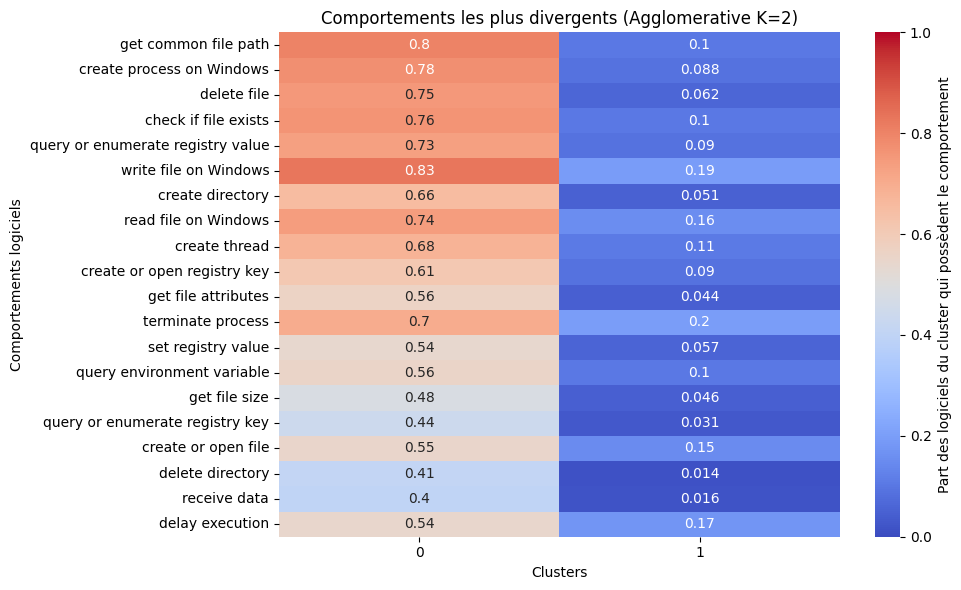

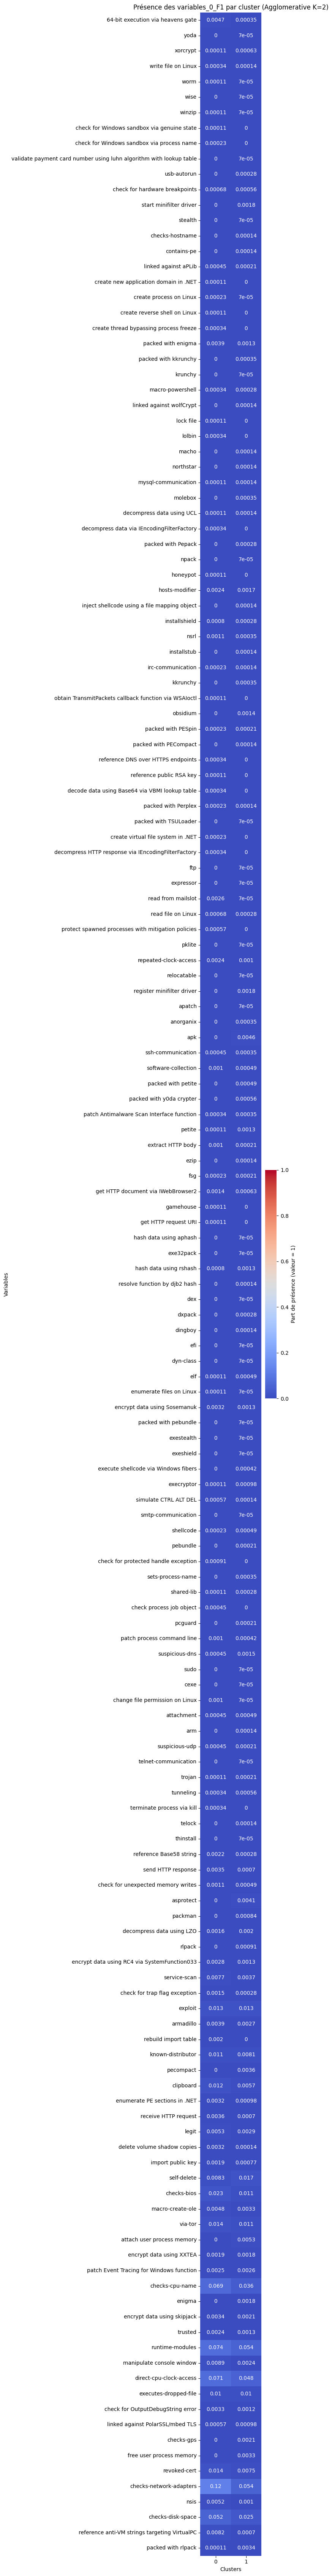

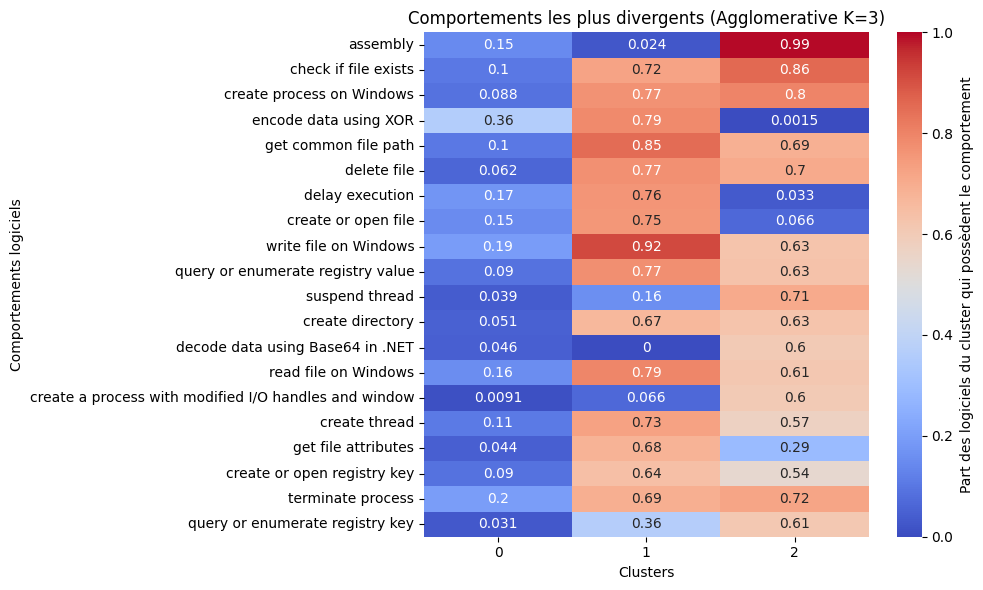

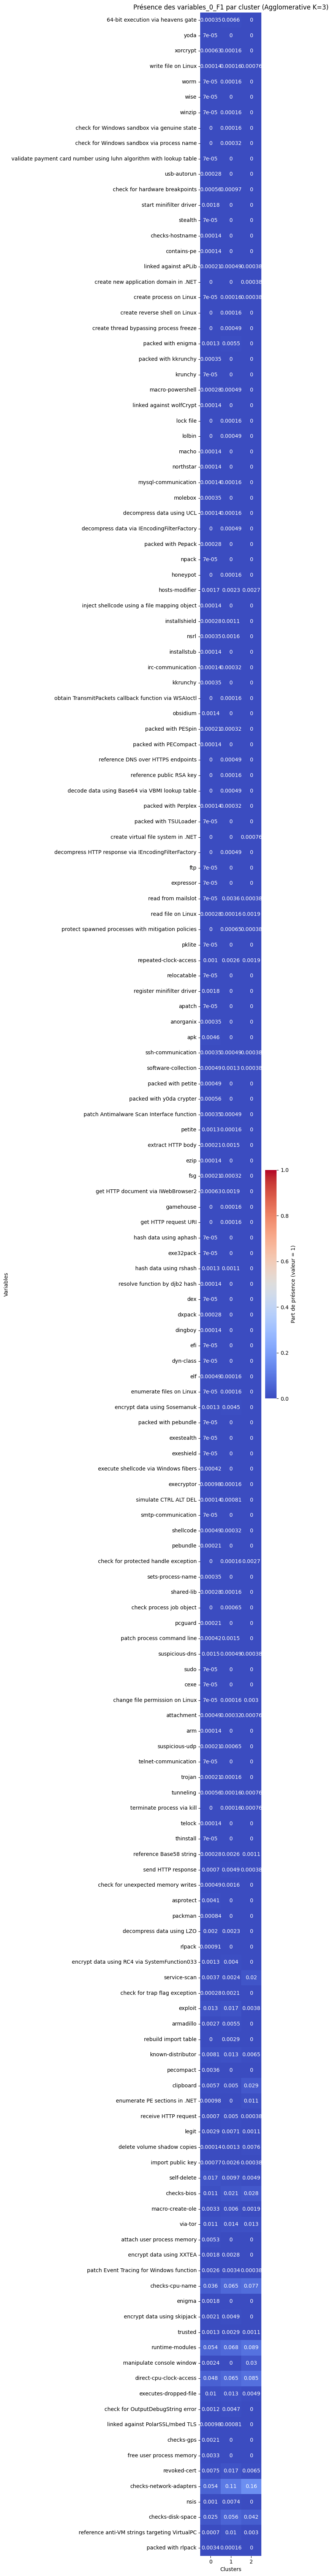

In [28]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def train_agglomerative_filling_model(metadata_train, n_clusters=3):
    X = metadata_train.iloc[:, 1:]  # Exclure l'ID
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = model.fit_predict(X)
    metadata_train["Cluster"] = labels
    cluster_means = metadata_train.iloc[:, 1:].groupby("Cluster").mean()
    return model, labels, cluster_means

def fill_missing_behaviors(known_behaviors, cluster_means):
    known_behaviors = np.array(known_behaviors).reshape(1, -1)
    mask_known = (known_behaviors != -1).reshape(-1)
    distances = []
    for i, cluster_center in enumerate(cluster_means.values):
        center_filtered = cluster_center[mask_known]
        known_filtered = known_behaviors[0][mask_known]
        distance = np.linalg.norm(center_filtered - known_filtered)
        distances.append(distance)
    best_cluster = np.argmin(distances)
    filled_behaviors = known_behaviors.copy()
    for i in range(len(filled_behaviors[0])):
        if filled_behaviors[0][i] == -1:
            filled_behaviors[0][i] = 1 if cluster_means.iloc[best_cluster, i] > 0.5 else 0
    return filled_behaviors[0], best_cluster

# === EXÉCUTION ===
list_cluster = [2, 3]
agglo_models = {}
cluster_means_dict = {}

for nb_cluster in list_cluster:
    metadata_train = pd.read_csv("data/training_set_metadata.csv", sep=";")

    model, labels, cluster_means = train_agglomerative_filling_model(metadata_train, n_clusters=nb_cluster)
    agglo_models[nb_cluster] = model
    cluster_means_dict[nb_cluster] = cluster_means

    # === HEATMAP des comportements les plus divergents
    divergent_features = cluster_means.var().sort_values(ascending=False).head(20).index
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(cluster_means[divergent_features].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Part des logiciels du cluster qui possèdent le comportement')
    plt.title(f"Comportements les plus divergents (Agglomerative K={nb_cluster})")
    plt.ylabel("Comportements logiciels")
    plt.xlabel("Clusters")
    plt.tight_layout()
    plt.show()

    # === HEATMAP des variables_0_F1
    variables_intersect = [v for v in variables_0_F1_sara if v in cluster_means.columns]
    if variables_intersect:
        plt.figure(figsize=(8, len(variables_intersect) * 0.4 + 2))
        ax = sns.heatmap(cluster_means[variables_intersect].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
        cbar = ax.collections[0].colorbar
        cbar.set_label('Part de présence (valeur = 1)')
        plt.title(f"Présence des variables_0_F1 par cluster (Agglomerative K={nb_cluster})")
        plt.ylabel("Variables")
        plt.xlabel("Clusters")
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Aucune variable de `variables_0_F1` trouvée dans les colonnes (K={nb_cluster})")


In [ ]:
# === PREDICTION ===

for K in list_cluster:
    selected_k = K
    cluster_means = cluster_means_dict[selected_k]

    results = []

    for idx, row in metadata_predict.iterrows():
        software_id = row.iloc[0]
        new_software_behaviors = row.iloc[1:].values  # tableau numpy avec 0, 1 ou -1

        # Prédiction des valeurs manquantes
        predicted_behaviors, predicted_cluster = fill_missing_behaviors(new_software_behaviors, cluster_means)

        # Construction de la ligne de résultat
        result_row = [software_id] + list(predicted_behaviors) + [predicted_cluster]
        results.append(result_row)

    # Construction des noms de colonnes : ID + comportements + cluster prédit
    columns = [metadata_predict.columns[0]] + list(metadata_predict.columns[1:]) + ['predicted_cluster']
    results_df = pd.DataFrame(results, columns=columns)

    # Affichage résumé
    print(f"✅ Résumé pour Agglomerative K={K} :\n{results_df.groupby('predicted_cluster').count().iloc[:, 0]}\n")

    # Export Excel
    output_path = f"output/metadata_predict_agglomerative_completed_K{K}.xlsx"
    results_df.to_excel(output_path, index=False)
    print(f"📁 Fichier sauvegardé : {output_path}")


# K modes

In [10]:
! pip install kmodes



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


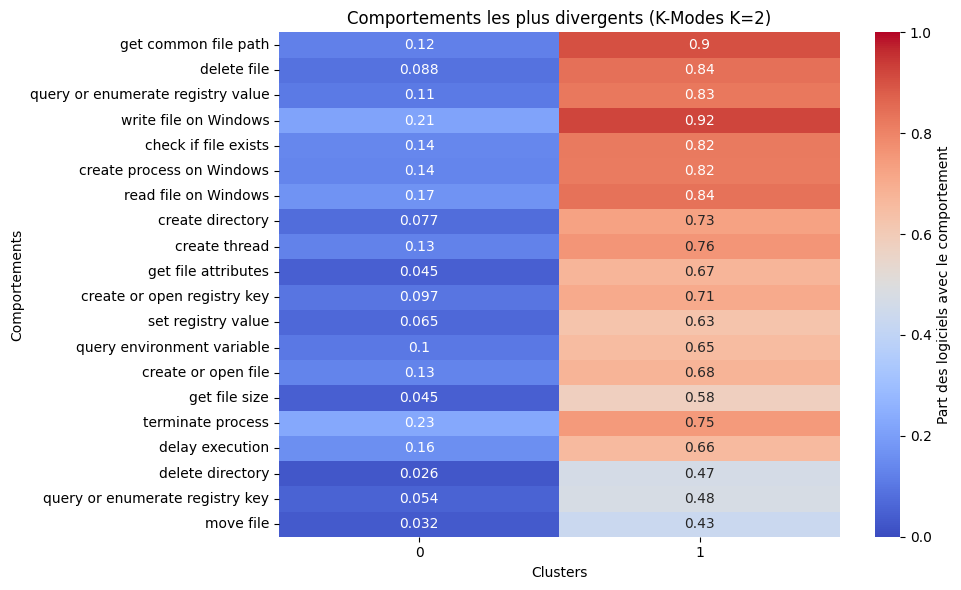

NameError: name 'variables_0_F1' is not defined

In [ ]:
from kmodes.kmodes import KModes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def train_kmodes_filling_model(metadata_train, n_clusters=3):
    """
    Entraîne un modèle K-Modes sur des données binaires ou catégoriques.
    """
    X = metadata_train.iloc[:, 1:]  # Exclure l'ID
    model = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
    labels = model.fit_predict(X)
    metadata_train["Cluster"] = labels
    cluster_means = metadata_train.iloc[:, 1:].groupby("Cluster").mean()
    return model, labels, cluster_means

def fill_missing_behaviors(known_behaviors, cluster_means):
    """
    Impute les -1 selon la moyenne du cluster le plus proche.
    """
    known_behaviors = np.array(known_behaviors).reshape(1, -1)
    mask_known = (known_behaviors != -1).reshape(-1)

    distances = []
    for i, cluster_center in enumerate(cluster_means.values):
        center_filtered = cluster_center[mask_known]
        known_filtered = known_behaviors[0][mask_known]
        distance = np.linalg.norm(center_filtered - known_filtered)
        distances.append(distance)

    best_cluster = np.argmin(distances)

    filled_behaviors = known_behaviors.copy()
    for i in range(len(filled_behaviors[0])):
        if filled_behaviors[0][i] == -1:
            filled_behaviors[0][i] = 1 if cluster_means.iloc[best_cluster, i] > 0.5 else 0

    return filled_behaviors[0], best_cluster

# === EXÉCUTION ===
list_cluster = [2,3]
kmodes_models = {}
cluster_means_dict = {}

# ✅ Ta liste de variables à suivre :

for nb_cluster in list_cluster:
    metadata_train = pd.read_csv("data/training_set_metadata.csv", sep=";")
    kmodes_model, labels, cluster_means = train_kmodes_filling_model(metadata_train, n_clusters=nb_cluster)
    kmodes_models[nb_cluster] = kmodes_model
    cluster_means_dict[nb_cluster] = cluster_means

    # 🔥 Heatmap comportements les plus divergents
    divergent_features = cluster_means.var().sort_values(ascending=False).head(20).index
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(cluster_means[divergent_features].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    ax.collections[0].colorbar.set_label("Part des logiciels avec le comportement")
    plt.title(f"Comportements les plus divergents (K-Modes K={nb_cluster})")
    plt.ylabel("Comportements")
    plt.xlabel("Clusters")
    plt.tight_layout()
    plt.show()

    # ✅ Heatmap des variables_0_F1
    variables_intersect = [v for v in variables_below_10 if v in cluster_means.columns]
    if variables_intersect:
        plt.figure(figsize=(8, len(variables_intersect) * 0.4 + 2))
        ax = sns.heatmap(cluster_means[variables_intersect].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
        ax.collections[0].colorbar.set_label("Part de présence (valeur = 1)")
        plt.title(f"Présence des variables_0_F1 par cluster (K-Modes K={nb_cluster})")
        plt.ylabel("Variables")
        plt.xlabel("Clusters")
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Aucune variable de `variables_0_F1` trouvée dans les colonnes pour K={nb_cluster}")

# === PRÉDICTION ===


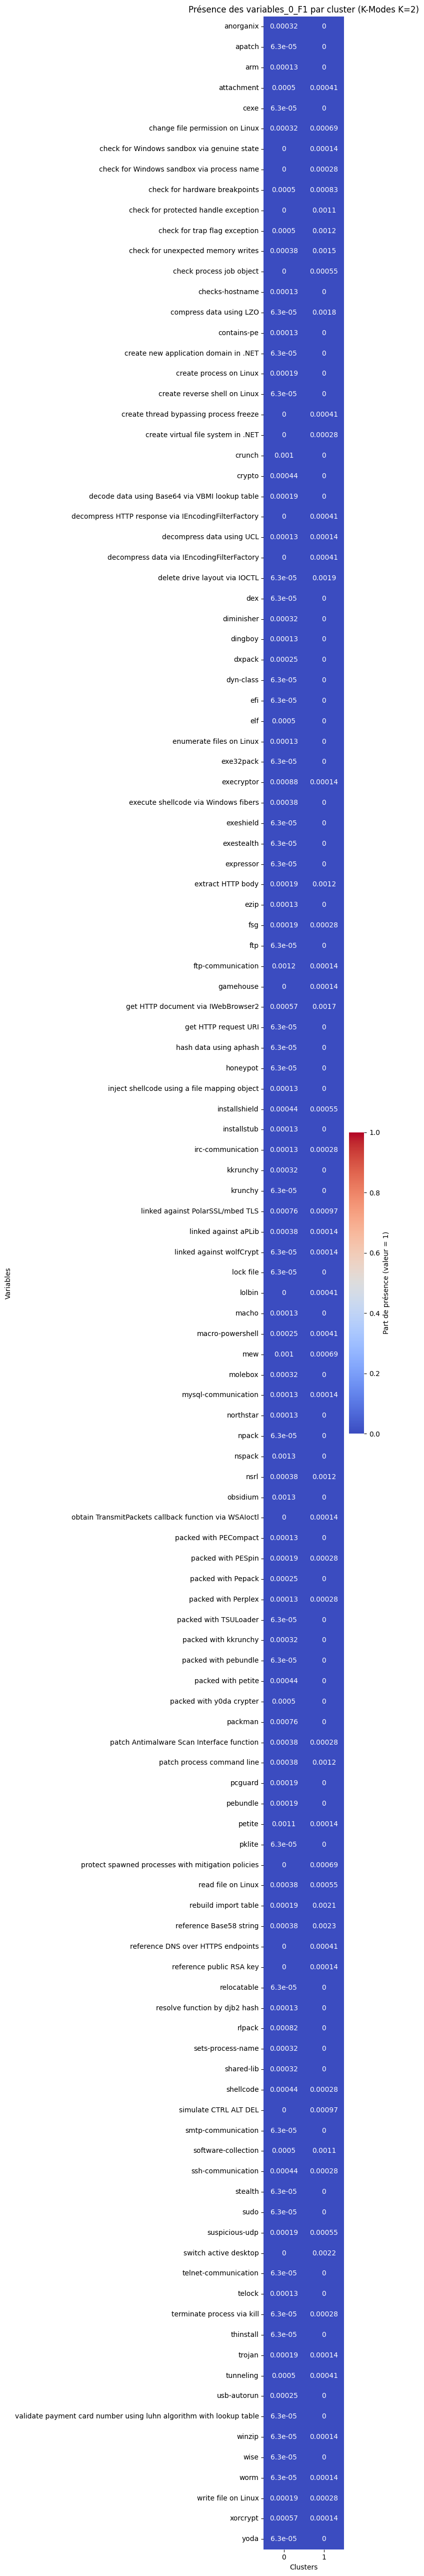

In [19]:
variables_intersect = [v for v in variables_below_10 if v in cluster_means.columns]
if variables_intersect:
        plt.figure(figsize=(8, len(variables_intersect) * 0.4 + 2))
        ax = sns.heatmap(cluster_means[variables_intersect].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
        ax.collections[0].colorbar.set_label("Part de présence (valeur = 1)")
        plt.title(f"Présence des variables_0_F1 par cluster (K-Modes K={nb_cluster})")
        plt.ylabel("Variables")
        plt.xlabel("Clusters")
        plt.tight_layout()
        plt.show()
   
   

In [22]:

for K in list_cluster:
    selected_k = K
    cluster_means = cluster_means_dict[selected_k]

    results = []
    for idx, row in metadata_predict.iterrows():
        new_software_behaviors = row.iloc[1:].values
        predicted_behaviors, predicted_cluster = fill_missing_behaviors(new_software_behaviors, cluster_means)
        result_row = [row.iloc[0]] + list(predicted_behaviors) + [predicted_cluster]
        results.append(result_row)

    columns = [metadata_predict.columns[0]] + list(metadata_predict.columns[1:]) + ['predicted_cluster']
    results_df = pd.DataFrame(results, columns=columns)

    print(f"Nombre de clusters {selected_k}:\n{results_df.groupby(['predicted_cluster']).count().iloc[:, 0]}\n")

    results_df.iloc[:, :-1].to_excel(f"output/metadata_predict_THY_completed_kmodes_{selected_k}.xlsx", index=False)

Nombre de clusters 2:
predicted_cluster
0    1982
1    1018
Name: name, dtype: int64

Nombre de clusters 3:
predicted_cluster
0    1989
1     776
2     235
Name: name, dtype: int64



# SKLEARN

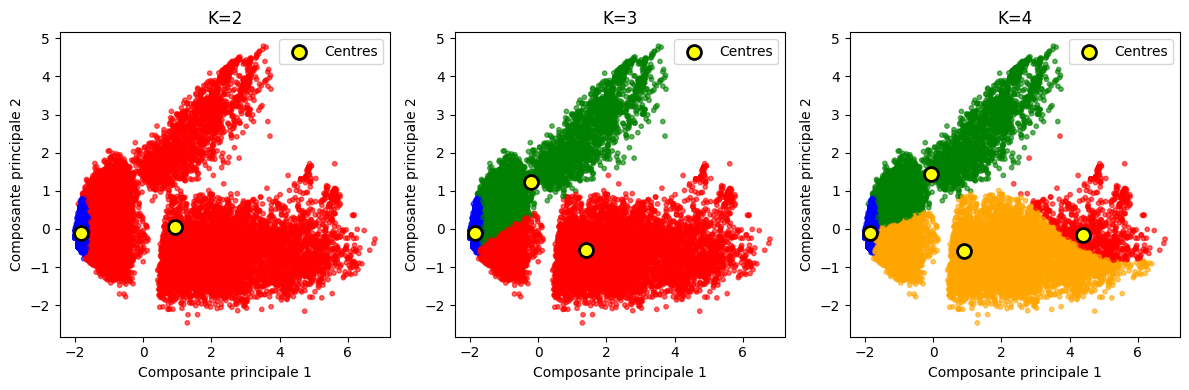

In [ ]:
# Réduction de dimension avec PCA pour la visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(metadata_train.iloc[:, 1:])  # Suppression de la première colonne si besoin

# Définition des couleurs pour les clusters
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

# Appliquer GMM avec différents nombres de clusters
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(X_pca)
gmm3 = GaussianMixture(n_components=3, covariance_type='full', random_state=42).fit(X_pca)
gmm4 = GaussianMixture(n_components=4, covariance_type='full', random_state=42).fit(X_pca)

# Création de la figure pour afficher les résultats
plt.figure(figsize=(12, 4))

# Liste des modèles et titres
gmm_models = [gmm2, gmm3, gmm4]
titles = ["K=2", "K=3", "K=4"]

for i, gmm in enumerate(gmm_models):
    plt.subplot(1, 3, i + 1)
    
    # Prédiction des clusters
    labels = gmm.predict(X_pca)
    
    # Affichage des points colorés par cluster
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[colors[lab] for lab in labels], alpha=0.6, s=10)

    # Affichage des centres des clusters
    plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], edgecolor='black', marker="o", s=100, facecolor="yellow", linewidth=2, label="Centres")

    plt.title(titles[i])
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.legend()

plt.tight_layout()
plt.show()


## DB SCAN

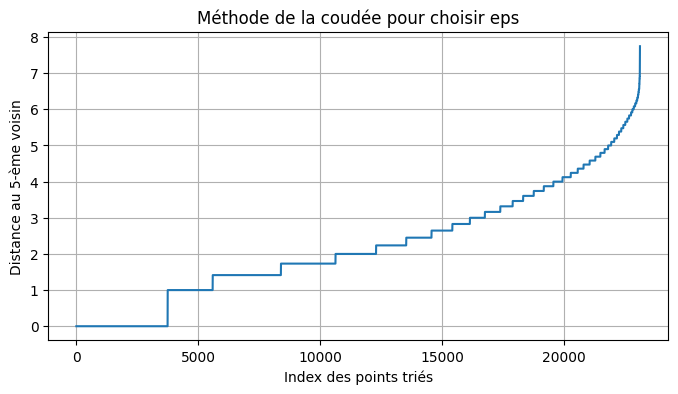

In [162]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Sélection des données sans réduction de dimension
X = metadata_train.iloc[:, 1:]

# Choisir k = min_samples (généralement 4 ou 5 pour débuter)
k = 5
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)

# On prend la distance du k-ème voisin
distances = np.sort(distances[:, k-1], axis=0)

# Tracer la courbe
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Index des points triés")
plt.ylabel(f"Distance au {k}-ème voisin")
plt.title("Méthode de la coudée pour choisir eps")
plt.grid()
plt.show()


C:\Users\lucas\AppData\Local\Temp\ipykernel_46676\3048890223.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_pca[class_member_mask, 0], X_pca[class_member_mask, 1], c=col, label=f"Cluster {k}", alpha=0.6, edgecolors="k")


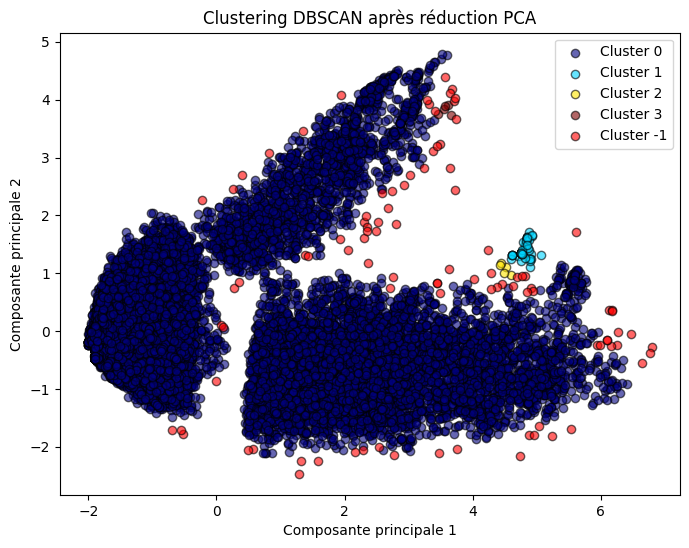

In [169]:

# Réduction de dimension avec PCA pour la visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(metadata_train.iloc[:, 1:])  # Suppression de la première colonne si besoin

# Appliquer DBSCAN (il faut ajuster eps et min_samples en fonction des données)
dbscan = DBSCAN(eps=0.15, min_samples=5).fit(X_pca)

# Récupérer les labels de clusters (valeur -1 = bruit / outliers)
labels = dbscan.labels_

# Définition des couleurs
unique_labels = set(labels)
colors = [plt.cm.jet(float(i) / max(unique_labels)) for i in unique_labels]

# Affichage des clusters
plt.figure(figsize=(8, 6))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Les outliers sont en noir
        col = "red"

    plt.scatter(X_pca[class_member_mask, 0], X_pca[class_member_mask, 1], c=col, label=f"Cluster {k}", alpha=0.6, edgecolors="k")

plt.title("Clustering DBSCAN après réduction PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.show()
